<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego colab a google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importo le librerie necessarie

In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.1 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show
import torch.nn as nn
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import torchvision
from osgeo import gdal
import cv2
import tifffile as tiff

gpu

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Definisco alcune directory

In [5]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

Media e std calcolate in Funzioni.ipynb

In [6]:
# mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
# std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
mean = [0.0, 0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0, 1.0]

Definisco le traformazioni

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Definiamo la classe SARDataset

In [7]:
class SARDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]


        # Leggi l'immagine con tifffile
        image = tiff.imread(image_path)
        # if image.ndim == 3:
        #     image = np.transpose(image, (1, 2, 0))  # Trasponi per avere (H, W, C)
        # else:
        #     image = np.expand_dims(image, axis=-1)  # Se l'immagine ha un solo canale

        # Leggi la maschera con tifffile
        mask = tiff.imread(mask_path)
        if mask.ndim == 3:
            mask = mask[:, :, 0]  # Se la maschera ha più canali, prendi solo il primo

        # Normalizzazione della maschera
        mask = mask.astype(np.float32)
        mask[mask == 255.0] = 1.0


        # Verifica che le dimensioni corrispondano
        if image.shape[:2] != mask.shape:
            raise ValueError(f"Le dimensioni dell'immagine {image_path} e della maschera {mask_path} non corrispondono.")

        # Applica trasformazioni se specificato
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]



        return image, mask

Carico i percorsi delle immagini per il training, il validation e il test set

In [8]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]
train_label_paths = [line[1] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]
val_label_paths = [line[1] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]
test_label_paths = [line[1] for line in test_data]

Creo il modello UNET

Classe DoubleConv

In [9]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)



Classe UNET

In [10]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=4, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

Test

In [10]:
def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == "__main__":
  test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


Definisco costanti per il training

In [11]:
learning_rate = 1e-4
batch_size = 32
num_epochs = 5
num_workers = 16
image_height = 128
image_width = 128
pin_memory = True
load_model = False

Seed

In [12]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

Funzione per il training

In [12]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.float().unsqueeze(1).to(device=device)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())

        torch.cuda.empty_cache()


Funzione main

In [17]:
def main():
    train_transforms = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            # A.RandomRotate90(p=1.0),
            # A.HorizontalFlip(p=0.5),
            # A.VerticalFlip(p=0.5),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=4, out_channels=1).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader = get_loaders(
        train_image_paths,
        train_label_paths,
        val_image_paths,
        val_label_paths,
        batch_size,
        train_transforms,
        train_transforms,
        num_workers,
        pin_memory,
    )

    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)
        check_accuracy(val_loader, model, device=device)
        save_predictions_as_imgs(val_loader, model, folder=os.path.join(drive_dir, "saved_images"), device=device)

if __name__ == "__main__":
    main()

100%|██████████| 75/75 [07:43<00:00,  6.18s/it, loss=0.402]


=> Saving checkpoint
Got 10473713/11141120 with acc 94.01
Dice score: 0.006112356204539537


Saving predictions:   9%|▉         | 2/22 [02:42<27:07, 81.36s/it]


OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/saved_images/pred_82.tif'

Utils

In [14]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

Loaders

In [13]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
    train_dataset = SARDataset(train_image_paths, train_label_paths, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
    val_dataset = SARDataset(val_image_paths, val_label_paths, transform=train_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

Accuracy

In [15]:
def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

  print(
      f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
  )
  print(f"Dice score: {dice_score/len(loader)}")

  model.train()

In [16]:
def save_predictions_as_imgs(loader, model, folder, device="cuda"):
    os.makedirs(folder, exist_ok=True)  # Crea la cartella se non esiste già
    model.eval()  # Imposta il modello in modalità valutazione

    for idx, (x, y) in enumerate(tqdm(loader, desc="Saving predictions")):
        x = x.to(device=device)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        # Salva le previsioni come immagine TIFF
        for i in range(preds.shape[0]):
            pred_tiff_path = os.path.join(folder, f"pred_{idx * loader.batch_size + i}.tif")
            tiff.imwrite(pred_tiff_path, preds[i].cpu().numpy().astype('float32'))

        # Salva le etichette come immagine TIFF
        for i in range(y.shape[0]):
            label_tiff_path = os.path.join(folder, f"label_{idx * loader.batch_size + i}.tif")
            tiff.imwrite(label_tiff_path, y[i].cpu().numpy().astype('float32'))

    model.train()


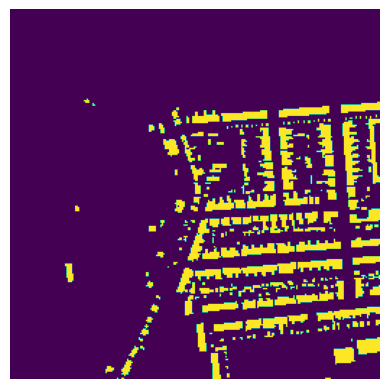

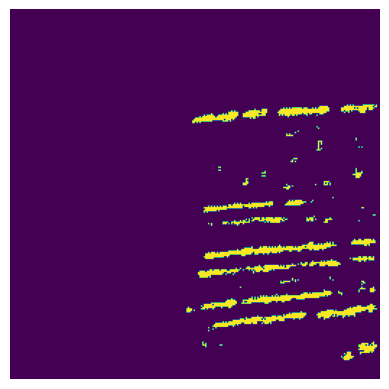

In [25]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Funzione per visualizzare un'immagine TIFF
def visualize_tiff(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()  # Leggi l'immagine
        img = np.transpose(img, (1, 2, 0))  # Trasponi per l'ordine delle dimensioni corretto
        plt.imshow(img)  # Mostra l'immagine
        plt.axis('off')  # Disabilita gli assi
        plt.show()

# Percorso dell'immagine da visualizzare
image_path = drive_dir + '/saved_images/label_6.tif'

# Visualizza l'immagine
visualize_tiff(image_path)

image_path = drive_dir + '/saved_images/pred_6.tif'

visualize_tiff(image_path)
